# Import and Prep the data

In [23]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Ground truth models
climatology_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/climatology_732x7x49x69.nc')
climatology = {
    'name': 'climatology',
    'data': climatology_data
}

analysis_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/ground_truth_analysis_732x7x49x69.nc')
analysis = {
    'name': 'analysis',
    'data': analysis_data
}

era_ground_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\ground_truth_era5_732x7x49x69.nc')
era_ground = {
    'name': 'era_ground',
    'data': era_ground_data

}

# NWP models
hres_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\hres_732x7x49x69.nc')
hres = {
    'name': 'hres',
    'data': hres_data
}

era5_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\era5_732x7x49x69.nc')
era5 = {
    'name': 'era5',
    'data': era5_data
}

# AIWP models
graphcast_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/graphcast_732x7x49x69.nc')
graphcast = {
    'name': 'graphcast',
    'data': graphcast_data
}

fuxi_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/fuxi_702x7x49x69.nc')
fuxi = {
    'name': 'fuxi',
    'data': fuxi_data
}

keisler_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\keisler_732x7x49x69.nc')
keisler = {
    'name': 'keisler',
    'data': keisler_data
}

pangu_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/pangu_732x7x49x69.nc')
pangu = {
    'name': 'pangu',
    'data': pangu_data
}

# SA-GNN Model

sagnn_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/sagnn_726x6x49x69.nc')
sagnn = {
    'name': 'sagnn',
    'data': sagnn_data
}

In [2]:
sagnn_data

<xarray.Dataset> Size: 59MB
Dimensions:               (time: 726, prediction_timedelta: 6, latitude: 49,
                           longitude: 69)
Coordinates:
  * time                  (time) datetime64[ns] 6kB 2020-01-01T12:00:00 ... 2...
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 48B 06:00:00...
  * latitude              (latitude) float64 392B -35.0 -34.75 ... -23.25 -23.0
  * longitude             (longitude) float64 552B 16.0 16.25 ... 32.75 33.0
    level                 int32 4B ...
Data variables:
    wind_speed            (time, prediction_timedelta, latitude, longitude) float32 59MB ...
Attributes:
    description:  Wind speed at 850 hPa predictions and targets
    units:        m/s

# Intensity and Anomalies

In [3]:
class Metric:
    def __init__(self, base, test):
        self.base_name = base['name']
        self.test_name = test['name']

        self.base = base['data'].load()
        self.test = test['data'].load()

        self.base = self.base.dropna('time')
        self.test = self.test.dropna('time')

        self.results = {
            'hres': [],
            'era5': [],
            'graphcast': [],
            'fuxi': [],
            'keisler': [],
            'pangu': [],
            'sagnn': []
        }

        self.align_datasets()
    
    
    def align_datasets(self):
        if not np.array_equal(self.base.time, self.test.time):
            print('\tAligning datasets on time dimension')
            common_times = np.intersect1d(self.base.time, self.test.time)
            self.base = self.base.sel(time=common_times)
            self.test = self.test.sel(time=common_times)

        if not np.array_equal(self.base.latitude, self.test.latitude) or not np.array_equal(self.base.longitude, self.test.longitude):
            print('\tTest regrid to base coordinates')
            self.test = self.test.interp(latitude=self.base.latitude, longitude=self.base.longitude)

        if self.test.prediction_timedelta.size == 7:
            self.test = self.test.isel(prediction_timedelta=slice(1, 7))

        if  self.base.prediction_timedelta.size != self.test.prediction_timedelta.size:
            print('\tAligning datasets on prediction_timedelta dimension')
            self.base = self.base.sel(prediction_timedelta=self.test.prediction_timedelta)
    

    def spatial_bias(self):
        return (self.test - self.base)
    

    def spatial_mae(self):
       return abs(self.spatial_bias())
    

    def spatial_mse(self):
        return (self.spatial_bias()**2)
    

    def spatial_rmse(self):
        return (self.spatial_mse())**0.5
    

    def spatial_mape(self):
        return abs(self.spatial_bias()/self.base) * 100
    

    def spatial_rmspe(self):
        return (self.spatial_mape()**2)**0.5
    

    def bias(self):
        bias = weighted_spatial_average(self.spatial_bias())
        return bias.mean(dim='time')
    

    def mae(self):
        mae = weighted_spatial_average(self.spatial_mae())
        return mae.mean(dim='time')
    

    def mse(self):
        mse = weighted_spatial_average(self.spatial_mse())
        return mse.mean(dim='time')
    

    def rmse(self):
        rmse = weighted_spatial_average(self.spatial_rmse())
        return rmse.mean(dim='time')
    

    def mape(self):
        mape = weighted_spatial_average(self.spatial_mape())
        return mape.mean(dim='time')
    

    def rmspe(self):
        rmspe = weighted_spatial_average(self.spatial_rmspe())
        return rmspe.mean(dim='time')


    def correlation(self):
        correlations = []
        for timedelta in range(self.base.prediction_timedelta.size):
            corr = np.corrcoef(self.base.wind_speed.values[:, timedelta].flatten(), self.test.wind_speed.values[:, timedelta].flatten())[0, 1]
            correlations.append(corr)
        
        return np.array(correlations)
    

    def correlation_wb(self):
        ### WeatherBench Begin
        climatology = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/climatology_732x7x49x69.nc')
        forecast_anomalies = self.test - climatology
        truth_anomalies = self.base - climatology
        correlations = (
                weighted_spatial_average(forecast_anomalies * truth_anomalies) /
                np.sqrt(
                    (weighted_spatial_average(forecast_anomalies**2)) *
                    (weighted_spatial_average(truth_anomalies**2))
                )
            )
        return correlations.mean(dim='time')

    def peirce_skill_score(self):
        return 1 - (self.mse() / self.mse().isel(prediction_timedelta=0))
### ------------------- WeatherBench ----------------------- ###

def _assert_increasing(x: np.ndarray):
  if not (np.diff(x) > 0).all():
    raise ValueError(f"array is not increasing: {x}")


def _latitude_cell_bounds(x: np.ndarray) -> np.ndarray:
  pi_over_2 = np.array([np.pi / 2], dtype=x.dtype)
  return np.concatenate([-pi_over_2, (x[:-1] + x[1:]) / 2, pi_over_2])


def _cell_area_from_latitude(points: np.ndarray) -> np.ndarray:
  """Calculate the area overlap as a function of latitude."""
  bounds = _latitude_cell_bounds(points)
  _assert_increasing(bounds)
  upper = bounds[1:]
  lower = bounds[:-1]

  return np.sin(upper) - np.sin(lower)


def get_lat_weights(ds: xr.Dataset) -> xr.DataArray:
  """Computes latitude/area weights from latitude coordinate of dataset."""
  weights = _cell_area_from_latitude(np.deg2rad(ds.latitude.data))
  weights /= np.mean(weights)
  weights = ds.latitude.copy(data=weights)
  return weights


def weighted_spatial_average(
    dataset: xr.Dataset,
) -> xr.Dataset:
  """Compute spatial average after applying region mask.

  Args:
    dataset: Metric dataset as a function of latitude/longitude.
    region: Region object (optional).
    skipna: Skip NaNs in spatial mean.

  Returns:
    dataset: Spatially averaged metric.
  """
  weights = get_lat_weights(dataset)
  return dataset.weighted(weights).mean(
      ["latitude", "longitude"], skipna=True)


def weighted_spatial_average_l2_norm(
        dataset: xr.Dataset,
    ) -> xr.Dataset:
    """Helper function to compute sqrt(spatial_average(ds**2))."""
    return np.sqrt(weighted_spatial_average(dataset**2, skipna=True))

### ----------------- WeatherBench End -------------------- ###

def spatial_average(dataset: xr.Dataset):
    return dataset.mean(dim=['latitude', 'longitude']).dropna('time')


def calculate_vars(image):
    kernel_sizes = np.arange(1, min(image.shape[0], image.shape[1]),5)

    vars = []

    for kernel_size in kernel_sizes:
        
        total_var = 0
        for i in range(0, image.shape[0]):
            
            if i + kernel_size > image.shape[0]:
                break


            for j in range(0, image.shape[1]):

                if j + kernel_size > image.shape[1]:
                    break

                total_var += np.var(image[i:i+kernel_size, j:j+kernel_size])

        steps = (image.shape[0] - kernel_size + 1) * (image.shape[1] - kernel_size + 1)
        
        if steps == 0:
            break
        avg_var = total_var / steps
        vars.append(avg_var)
    return np.array(vars), kernel_sizes

    
def model_variance(models):

    for model in models:

        model_data = model['data']

        avg_variences = []

        for delta in range(0, model_data.prediction_timedelta.size):
            data = model_data.wind_speed.values[:, delta]

            variances = []

            for i in range(0, data.shape[0], 10):
                print(f'{delta} - {i}', end='\r')
                vars, ks = calculate_vars(data[i])
                variances.append(vars)

            
            variances = np.array(variances)
            variances = variances[~np.isnan(variances).any(axis=1)]

            avg_vars = np.mean(variances, axis=0)
            avg_variences.append(avg_vars)
        
        avg_variences = np.array(avg_variences)
        np.save(f'{model["name"]}_variances.npy', avg_variences)

    return ks

In [4]:
analysis = era_ground
models = [climatology, hres, era5, graphcast, fuxi, pangu, keisler, sagnn]
linestyles = [':', '-', '-', '--', '--', '--', '--', '--']
colors = ['black', 'red', 'firebrick', 'dodgerblue', 'darkturquoise', 'yellowgreen', 'darkgreen', 'blue']

available_metrics = {
    'spatial_bias': Metric.spatial_bias,
    'spatial_mae': Metric.spatial_mae,
    'spatial_mse': Metric.spatial_mse,
    'spatial_rmse': Metric.spatial_rmse,
    'spatial_mape': Metric.spatial_mape,
    'spatial_rmspe': Metric.spatial_rmspe,
    'bias': Metric.bias,
    'mae': Metric.mae,
    'mse': Metric.mse,
    'rmse': Metric.rmse,
    'mape': Metric.mape,
    'rmspe': Metric.rmspe,
    'correlation': Metric.correlation
}


def calculate_metric(models, metric, available_metrics=available_metrics):    
    results = {
        'hres': [],
        'era5': [],
        'graphcast': [],
        'fuxi': [],
        'keisler': [],
        'pangu': [],
        'era_ground': [],
        'climatology': [],
        'sagnn': []
    }

    for model in models:
        
        print(f'Calculating {metric} for {model["name"]}')
        
        metrics = Metric(analysis, model)
        
        error_metric = available_metrics[metric](metrics)
        
        results[metrics.test_name].append(error_metric.wind_speed.values)
    
    return results

def calculate_correlation(models):
    results = {
        'hres': [],
        'era5': [],
        'graphcast': [],
        'fuxi': [],
        'keisler': [],
        'pangu': [],
        'era_ground': [],
        'climatology': [],
        'sagnn': []
    }

    for model in models:
        print(f'Calculating correlation for {model["name"]}')
        
        metrics = Metric(analysis, model)
        
        correlations = metrics.correlation()
        
        results[metrics.test_name].append(correlations)
    
    return results

def calculate_correlation_wb(models):
    results = {
        'hres': [],
        'era5': [],
        'graphcast': [],
        'fuxi': [],
        'keisler': [],
        'pangu': [],
        'era_ground': [],
        'sagnn': []
    }

    for model in models:
        if model['name'] == 'climatology':
            continue
        print(f'Calculating correlation for {model["name"]}')
        
        metrics = Metric(analysis, model)
        
        correlations = metrics.correlation_wb()
        
        results[metrics.test_name].append(correlations.wind_speed.values)
    
    return results

# bias = calculate_metric(models, 'bias')
# mae = calculate_metric(models, 'mae')
rmse = calculate_metric(models, 'rmse')
# mape = calculate_metric(models, 'mape')
# rmspe = calculate_metric(models, 'rmspe')
correlation = calculate_correlation_wb(models)

Calculating rmse for climatology
	Aligning datasets on prediction_timedelta dimension
Calculating rmse for hres
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating rmse for era5
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating rmse for graphcast
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating rmse for fuxi
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating rmse for pangu
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating rmse for keisler
	Aligning datasets on prediction_timedelta dimension
Calculating rmse for sagnn
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating correlation for hres
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calcul

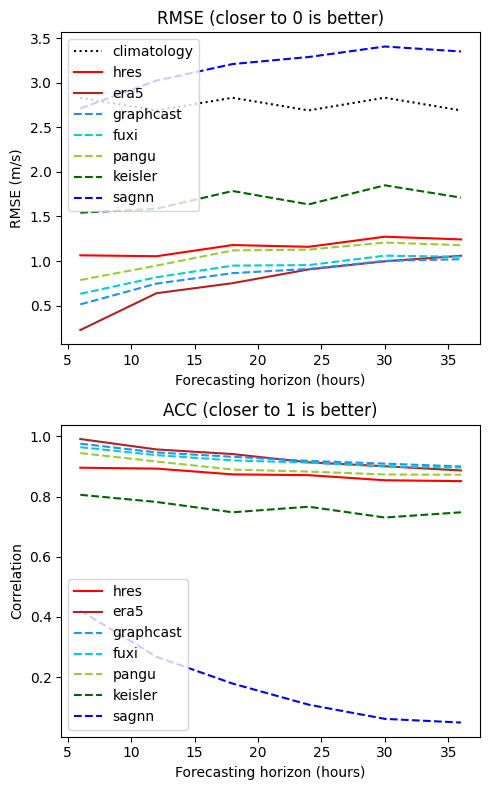

In [6]:
# Plotting

fig, axs = plt.subplots(2, 1, figsize=(5, 8))

x_lin = np.arange(6 , 37, 6)

for i, (model, linestyle, color) in enumerate(zip(models, linestyles, colors)):
    # axs[0, 0].plot(x_lin, mae[model['name']][0], label=model['name'], linestyle=linestyle)
    # axs[0, 0].set_title('MAE (closer to 0 is better)')
    # axs[0, 0].set_xlabel('Prediction timedelta')
    # axs[0, 0].set_ylabel('MAE (m/s)')

    rmse_fig = axs[0].plot(x_lin, rmse[model['name']][0], label=model['name'], linestyle=linestyle, color=color)
    axs[0].set_title('RMSE (closer to 0 is better)')
    axs[0].set_xlabel('Forecasting horizon (hours)')
    axs[0].set_ylabel('RMSE (m/s)')

    # axs[0, 2].plot(x_lin, mape[model['name']][0], label=model['name'], linestyle=linestyle)
    # axs[0, 2].set_title('MAPE (closer to 0 is better)')
    # axs[0, 2].set_xlabel('Prediction timedelta')
    # axs[0, 2].set_ylabel('MAPE (%)')

    # axs[1, 0].plot(x_lin, rmspe[model['name']][0], label=model['name'], linestyle=linestyle)
    # axs[1, 0].set_title('RMSPE (closer to 0 is better)')
    # axs[1, 0].set_xlabel('Prediction timedelta')
    # axs[1, 0].set_ylabel('RMSPE (%)')

    # axs[1, 1].plot(x_lin, bias[model['name']][0], label=model['name'], linestyle=linestyle)
    # axs[1, 1].set_title('Bias (closer to 0 is better)')
    # axs[1, 1].set_xlabel('Prediction timedelta')
    # axs[1, 1].set_ylabel('Bias (m/s)')

    if model['name'] == 'climatology':
        continue

    corr_fig = axs[1].plot(x_lin, correlation[model['name']][0], label=model['name'], linestyle=linestyle, color=color)
    axs[1].set_title('ACC (closer to 1 is better)')
    axs[1].set_xlabel('Forecasting horizon (hours)')
    axs[1].set_ylabel('Correlation')

for ax in axs:
    ax.legend()


plt.tight_layout()
plt.show()

# Variance

In [6]:
models = [sagnn]

ks = model_variance(models)
ks = np.arange(0, 49, 5)   

In [9]:
an_var = np.load('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/variances/analysis_variances.npy')
an_var = an_var[1:]
eg_var = np.load('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/variances/era_ground_variances.npy')
eg_var = eg_var[1:]
gc_var = np.load('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/variances/graphcast_variances.npy')
hr_var = np.load('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/variances/hres_variances.npy')
hr_var = hr_var[1:]
ea_var = np.load('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/variances/era5_variances.npy')
ea_var = ea_var[1:]
fx_var = np.load('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/variances/fuxi_variances.npy')
ks_var = np.load('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/variances/keisler_variances.npy')
ks_var = ks_var[1:]
pg_var = np.load('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/variances/pangu_variances.npy')
sagnn_var = np.load('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/variances/sagnn_variances.npy')
sagnn_var = sagnn_var[:-1]

In [8]:
an_var.shape, gc_var.shape, hr_var.shape, fx_var.shape, ks_var.shape, pg_var.shape, ea_var.shape, eg_var.shape, sagnn_var.shape

((6, 10),
 (6, 10),
 (6, 10),
 (6, 10),
 (5, 10),
 (6, 10),
 (6, 10),
 (6, 10),
 (5, 10))

In [9]:
# Matplotlib linestyles

# linestyles = ['-', '--', '-.', ':']

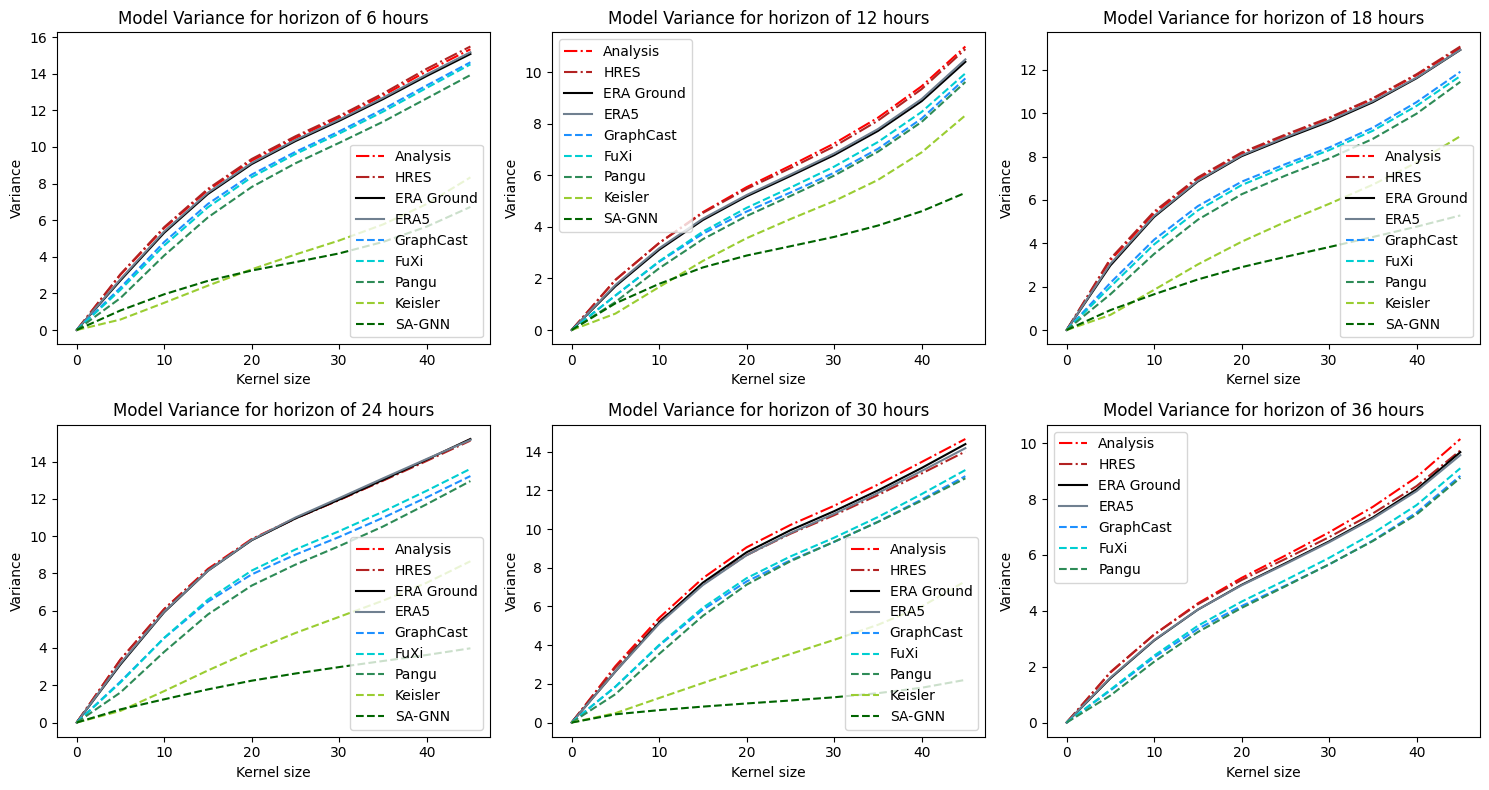

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i in range(0, 2):
    for j in range(0, 3):

        axs[i, j].plot(ks, an_var[i * 3 + j], label='Analysis', linestyle='-.', color='red')
        axs[i, j].plot(ks, hr_var[i * 3 + j], label='HRES', linestyle='-.', color='firebrick')
        axs[i, j].plot(ks, eg_var[i * 3 + j], label='ERA Ground', color= 'black')
        axs[i, j].plot(ks, ea_var[i * 3 + j], label='ERA5', color = 'slategray')
        
        axs[i, j].plot(ks, gc_var[i * 3 + j], label='GraphCast', linestyle='--', color='dodgerblue')
        axs[i, j].plot(ks, fx_var[i * 3 + j], label='FuXi', linestyle='--', color='darkturquoise')        
        axs[i, j].plot(ks, pg_var[i * 3 + j], label='Pangu', linestyle='--', color='seagreen')
        
        if i * 3 + j < 5:
            axs[i, j].plot(ks, ks_var[i * 3 + j], label='Keisler', linestyle='--', color='yellowgreen')
            axs[i, j].plot(ks, sagnn_var[i * 3 + j], label='SA-GNN', linestyle='--', color='darkgreen')


        axs[i, j].set_title(f'Model Variance for horizon of {(i *3 + j + 1) * 6} hours')
        axs[i, j].set_xlabel('Kernel size')
        axs[i, j].set_ylabel('Variance') #  (Models with less variance at smaller\n kernel size have more tendency to\n smooth forecasts)
        axs[i, j].legend()
        
plt.tight_layout()
plt.show()

# Together

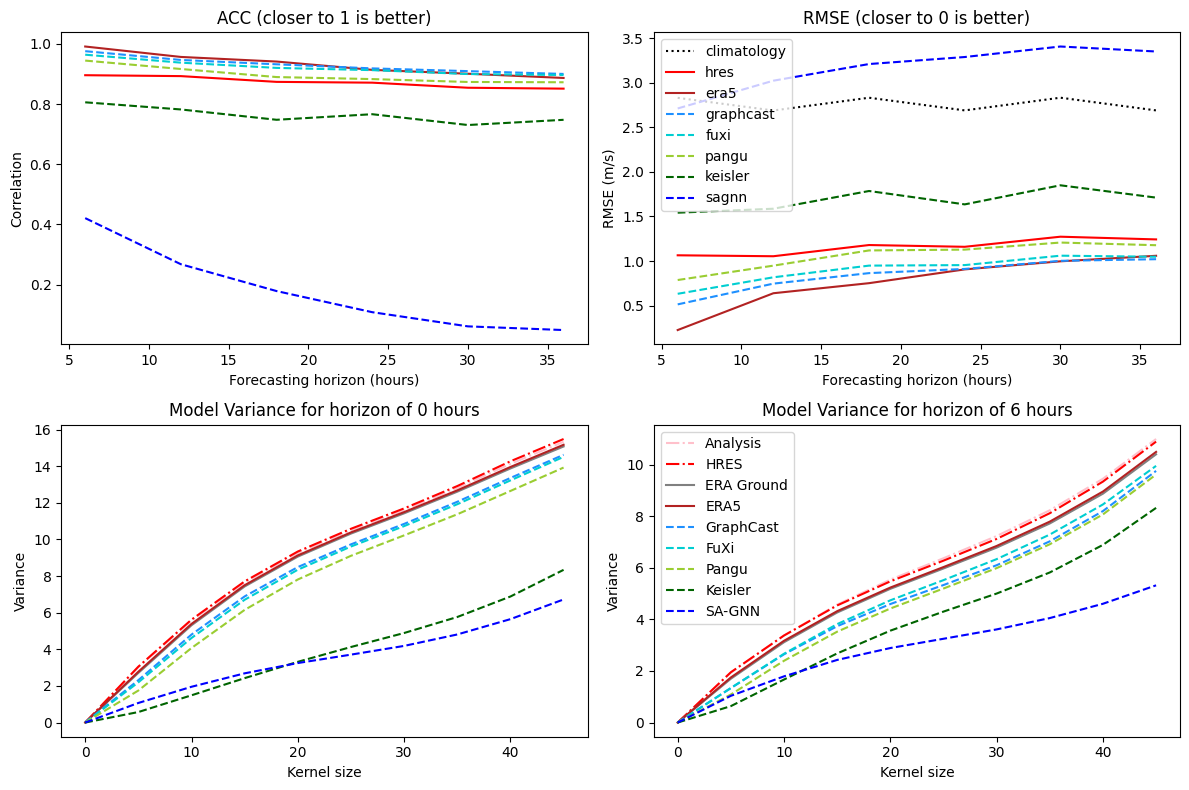

In [24]:
models = [climatology, hres, era5, graphcast, fuxi, pangu, keisler, sagnn]
linestyles = [':', '-', '-', '--', '--', '--', '--', '--']
colors = ['black', 'red', 'firebrick', 'dodgerblue', 'darkturquoise', 'yellowgreen', 'darkgreen', 'blue']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

x_lin = np.arange(6 , 37, 6)
ks = np.arange(0, 49, 5)   

for i, (model, linestyle, color) in enumerate(zip(models, linestyles, colors)):

    rmse_fig = axs[0, 1].plot(x_lin, rmse[model['name']][0], label=model['name'], linestyle=linestyle, color=color)
    axs[0, 1].set_title('RMSE (closer to 0 is better)')
    axs[0, 1].set_xlabel('Forecasting horizon (hours)')
    axs[0, 1].set_ylabel('RMSE (m/s)')

    if model['name'] == 'climatology':
        continue

    corr_fig = axs[0, 0].plot(x_lin, correlation[model['name']][0], label=model['name'], linestyle=linestyle, color=color)
    axs[0, 0].set_title('ACC (closer to 1 is better)')
    axs[0, 0].set_xlabel('Forecasting horizon (hours)')
    axs[0, 0].set_ylabel('Correlation')



for i in range(0, 2):

    axs[1, i].plot(ks, an_var[i], label='Analysis', linestyle='-.', color='pink')
    axs[1, i].plot(ks, hr_var[i], label='HRES', linestyle='-.', color='red')
    axs[1, i].plot(ks, eg_var[i], label='ERA Ground', color= 'grey')
    axs[1, i].plot(ks, ea_var[i], label='ERA5', color = 'firebrick')
    
    axs[1, i].plot(ks, gc_var[i], label='GraphCast', linestyle='--', color='dodgerblue')
    axs[1, i].plot(ks, fx_var[i], label='FuXi', linestyle='--', color='darkturquoise')        
    axs[1, i].plot(ks, pg_var[i], label='Pangu', linestyle='--', color='yellowgreen')
    
    axs[1, i].plot(ks, ks_var[i], label='Keisler', linestyle='--', color='darkgreen')
    axs[1, i].plot(ks, sagnn_var[i], label='SA-GNN', linestyle='--', color='blue')

    axs[1, i].set_title(f'Model Variance for horizon of {(i) * 6} hours')
    axs[1, i].set_xlabel('Kernel size')
    axs[1, i].set_ylabel('Variance') #  (Models with less variance at smaller\n kernel size have more tendency to\n smooth forecasts)


axs[0, 1].legend()
axs[1, 1].legend()


plt.tight_layout()
plt.show()

# Specific location plot

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


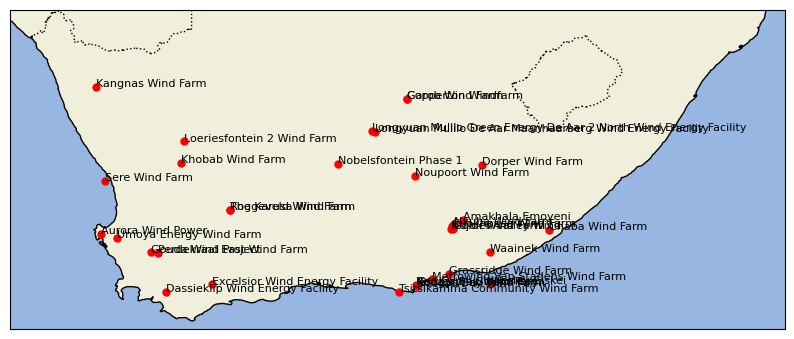

In [25]:
wind_farms = {
    "Aurora Wind Power": {"latitude": -32.9141, "longitude": 17.9911},
    "Gouda Wind Project": {"latitude": -33.3194, "longitude": 19.1000},
    "Jeffreys Bay Wind Farm": {"latitude": -34.0500, "longitude": 24.9200},
    "Nobelsfontein Phase 1": {"latitude": -31.3831, "longitude": 23.1906},
    "Sere Wind Farm": {"latitude": -31.7500, "longitude": 18.0833},
    "Amakhala Emoyeni": {"latitude": -32.6030, "longitude": 25.9280},
    "Chaba Wind Farm": {"latitude": -32.8250, "longitude": 27.8250},
    "Cookhouse Wind Farm": {"latitude": -32.7494, "longitude": 25.6931},
    "Copperton Windfarm": {"latitude": -29.9569, "longitude": 24.7083},
    "Dassieklip Wind Energy Facility": {"latitude": -34.1872, "longitude": 19.4328},
    "Dorper Wind Farm": {"latitude": -31.4072, "longitude": 26.3624},
    "Excelsior Wind Energy Facility": {"latitude": -34.0226, "longitude": 20.4417},
    "Garob Wind Farm": {"latitude": -29.9556, "longitude": 24.7081},
    "Golden Valley Wind": {"latitude": -32.7955, "longitude": 25.7254},
    "Grassridge Wind Farm": {"latitude": -33.7975, "longitude": 25.6251},
    "Kangnas Wind Farm": {"latitude": -29.6811, "longitude": 17.8778},
    "Khobab Wind Farm": {"latitude": -31.3500, "longitude": 19.7500},
    "Kouga Wind Farm": {"latitude": -34.0472, "longitude": 24.9225},
    "Loeriesfontein 2 Wind Farm": {"latitude": -30.8865, "longitude": 19.8085},
    "Longyuan Mulilo De Aar Maanhaarberg Wind Energy Facility": {"latitude": -30.6815, "longitude": 24.0125},
    "Longyuan Mulilo Green Energy De Aar 2 North Wind Energy Facility": {"latitude": -30.6485, "longitude": 23.9442},
    "Metrowind Van Stadens Wind Farm": {"latitude": -33.9126, "longitude": 25.2482},
    "Nojoli Wind Farm": {"latitude": -32.8081, "longitude": 25.6673},
    "Noupoort Wind Farm": {"latitude": -31.6381, "longitude": 24.8819},
    "Nxuba Wind Farm": {"latitude": -32.7071, "longitude": 25.7333},
    "Oyster Bay Wind Farm": {"latitude": -34.0261, "longitude": 24.9467},
    "Perdekraal East Wind Farm": {"latitude": -33.3400, "longitude": 19.2500},
    "Red Cap – Gibson Bay": {"latitude": -34.0333, "longitude": 24.9167},
    "Roggeveld Wind Farm": {"latitude": -32.3928, "longitude": 20.8311},
    "The Karusa Wind Farm": {"latitude": -32.3906, "longitude": 20.8242},
    "Tsitsikamma Community Wind Farm": {"latitude": -34.1862, "longitude": 24.5256},
    "Umoya Energy Wind Farm": {"latitude": -33.0011, "longitude": 18.3486},
    "Waainek Wind Farm": {"latitude": -33.3042, "longitude": 26.5247},
    "Wesley-Ciskei": {"latitude": -34.0167, "longitude": 26.5333}
}

# Plot all the wind farms on the map of SOuth Africa using cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([16, 33, -35, -28], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

for wind_farm, location in wind_farms.items():
    ax.plot(location['longitude'], location['latitude'], 'ro', markersize=5)
    ax.text(location['longitude'], location['latitude'], wind_farm, fontsize=8)

plt.show()

# Error map

In [11]:
analysis = era_ground
models = [climatology, hres, era5, graphcast, fuxi, pangu, keisler]
linestyles = [':', '-', '-', '--', '--', '--', '--']
colors = ['black', 'red', 'firebrick', 'dodgerblue', 'darkturquoise', 'yellowgreen', 'darkgreen']

bias = calculate_metric(models, 'spatial_mae')


Calculating spatial_mae for climatology
	Aligning datasets on prediction_timedelta dimension
Calculating spatial_mae for hres
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating spatial_mae for era5
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating spatial_mae for graphcast
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating spatial_mae for fuxi
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating spatial_mae for pangu
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating spatial_mae for keisler
	Aligning datasets on prediction_timedelta dimension


In [12]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axs:
    ax.coastlines()

err_mean = axs[0].contourf(analysis_data.longitude.values, analysis_data.latitude.values, np.mean(bias['hres'][0][:,5], axis=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
fig.colorbar(err_mean, ax=axs[0], orientation="vertical", label="Wind Speed levels", shrink=0.7, pad=0.02)

err_mean = axs[1].contourf(analysis_data.longitude.values, analysis_data.latitude.values, np.mean(bias['graphcast'][0][:,5], axis=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
fig.colorbar(err_mean, ax=ax, orientation="vertical", label="Wind Speed levels", shrink=0.7, pad=0.02)

NameError: name 'ccrs' is not defined

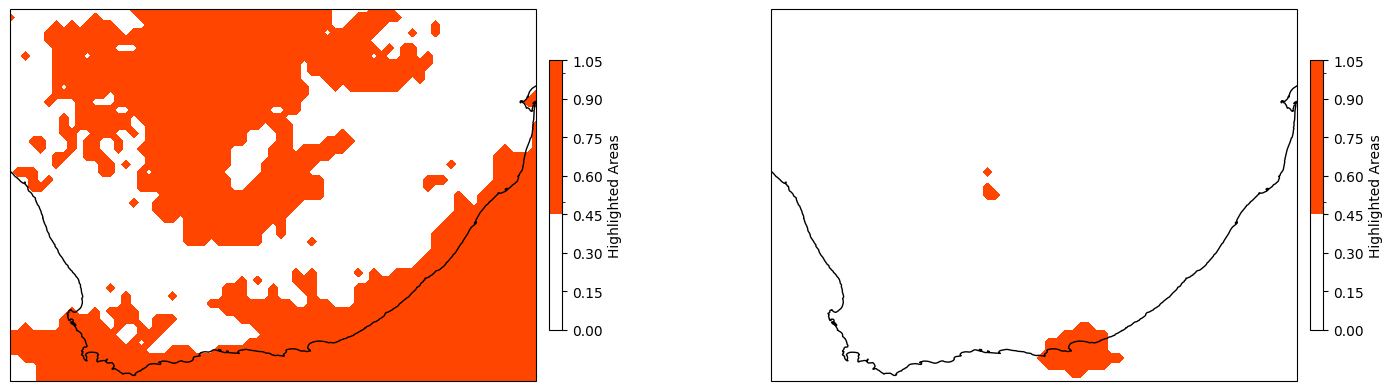

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, BoundaryNorm

# Generate custom colormap: white for non-red, red for red areas
colors = ['white', '#FF4500']  # Adjust the red color if necessary
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1], cmap.N)  # Adjust threshold for red values

fig, axs = plt.subplots(1, 2, figsize=(18, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axs:
    ax.coastlines()

# Example of how to use your data for masking
data1 = np.mean(bias['hres'][0][:, 5], axis=0)  # Adjust data as needed
data2 = np.mean(bias['graphcast'][0][:, 5], axis=0)  # Adjust data as needed

# Set data above a certain threshold to 1 (red) and the rest to 0 (white)
highlighted_data1 = np.where(data1 > 1.25, 1, 0)
highlighted_data2 = np.where(data2 > 1.35, 1, 0)

err_mean1 = axs[0].contourf(
    analysis_data.longitude.values, 
    analysis_data.latitude.values, 
    highlighted_data1, 
    transform=ccrs.PlateCarree(), 
    cmap=cmap, 
    norm=norm
)
fig.colorbar(err_mean1, ax=axs[0], orientation="vertical", label="Highlighted Areas", shrink=0.7, pad=0.02)

err_mean2 = axs[1].contourf(
    analysis_data.longitude.values, 
    analysis_data.latitude.values, 
    highlighted_data2, 
    transform=ccrs.PlateCarree(), 
    cmap=cmap, 
    norm=norm
)
fig.colorbar(err_mean2, ax=axs[1], orientation="vertical", label="Highlighted Areas", shrink=0.7, pad=0.02)

plt.show()


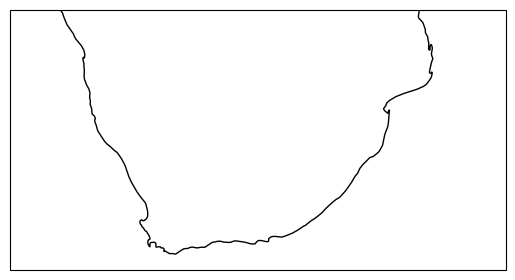

In [ ]:
# Blank map of coastlines of South Africa

import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.set_extent([10, 40, -35, -20])
plt.show()